In [27]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

df = pd.read_csv("XAUUSD_1H_BID_20241001-20241014.csv")
prices = df['Close'].values
prices

array([2636.255, 2639.675, 2636.318, 2637.845, 2639.464, 2642.955,
       2645.165, 2645.485, 2646.425, 2648.565, 2650.225, 2650.178,
       2651.435, 2667.528, 2658.895, 2663.315, 2666.315, 2662.298,
       2660.945, 2658.588, 2663.005, 2663.005, 2661.895, 2660.218,
       2657.325, 2660.495, 2659.998, 2655.238, 2653.958, 2647.875,
       2649.615, 2655.315, 2652.335, 2652.815, 2649.015, 2649.448,
       2649.488, 2659.344, 2647.945, 2649.835, 2649.638, 2652.025,
       2653.998, 2658.498, 2658.345, 2658.345, 2659.334, 2660.135,
       2657.675, 2658.105, 2655.665, 2655.878, 2654.845, 2653.198,
       2655.714, 2645.145, 2644.985, 2644.685, 2646.675, 2647.935,
       2642.235, 2646.925, 2650.068, 2648.735, 2659.925, 2656.595,
       2657.398, 2657.815, 2655.715, 2655.715, 2655.844, 2655.615,
       2657.098, 2658.115, 2661.908, 2660.985, 2663.915, 2667.278,
       2660.148, 2660.888, 2658.894, 2657.365, 2658.145, 2661.205,
       2638.695, 2651.778, 2658.255, 2653.045, 2645.168, 2649.

### FFT for the whole data length

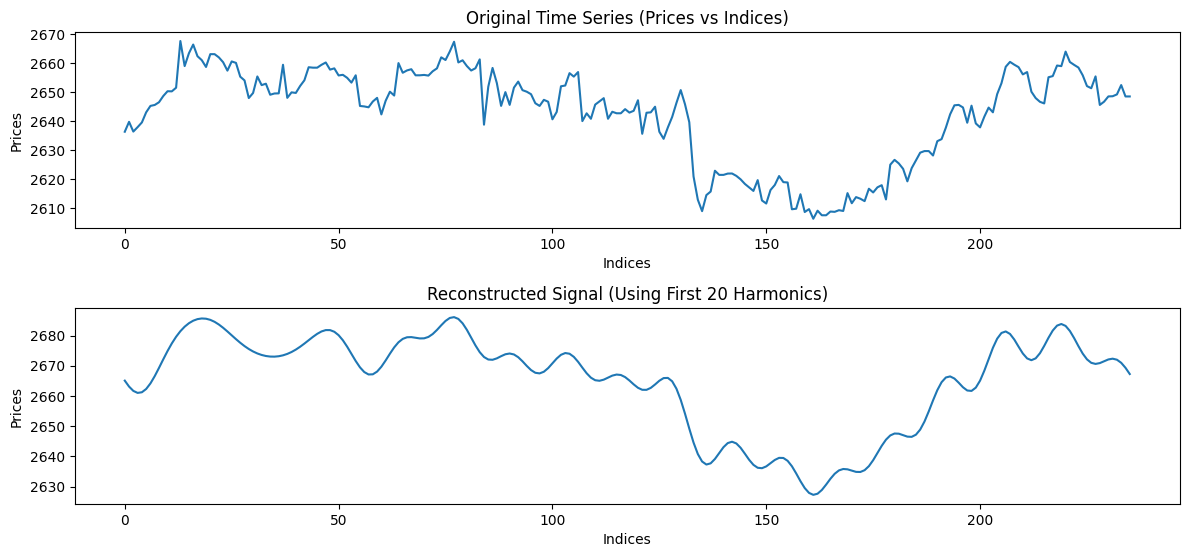

In [20]:

# Create time indices based on the length of prices (0 to len(prices) - 1)
time_indices = np.arange(len(prices))

# Perform FFT
fft_result = np.fft.fft(prices)
fft_freq = np.fft.fftfreq(len(prices))  # Compute frequency bins

# Filter out the negative frequencies (optional, for easier interpretation)
positive_freq_indices = fft_freq >= 0
fft_result_positive = fft_result[positive_freq_indices]
fft_freq_positive = fft_freq[positive_freq_indices]

# Retain only the first few harmonics, e.g., the first 3 frequencies
num_harmonics = 20
fft_result_filtered = np.zeros_like(fft_result_positive)
fft_result_filtered[:num_harmonics] = fft_result_positive[:num_harmonics]

# Perform inverse FFT to reconstruct the signal with only the first few harmonics
fft_full_filtered = np.concatenate([fft_result_filtered, np.conj(fft_result_filtered[-2:0:-1])])
reconstructed_signal = np.fft.ifft(fft_full_filtered)

# Ensure the lengths of time_indices and reconstructed_signal match
min_length = min(len(time_indices), len(reconstructed_signal))
time_indices = time_indices[:min_length]
reconstructed_signal = reconstructed_signal[:min_length]

# Plot original time series data
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time_indices, prices[:min_length])  # Truncate prices to match time_indices
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")

# Plot the reconstructed signal using only a few harmonics
plt.subplot(3, 1, 2)
plt.plot(time_indices, reconstructed_signal.real)  # Use the real part only, since FFT produces complex numbers
plt.title(f"Reconstructed Signal (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Prices")

plt.tight_layout()
plt.show()


### Forecasting, excluding last 48 data

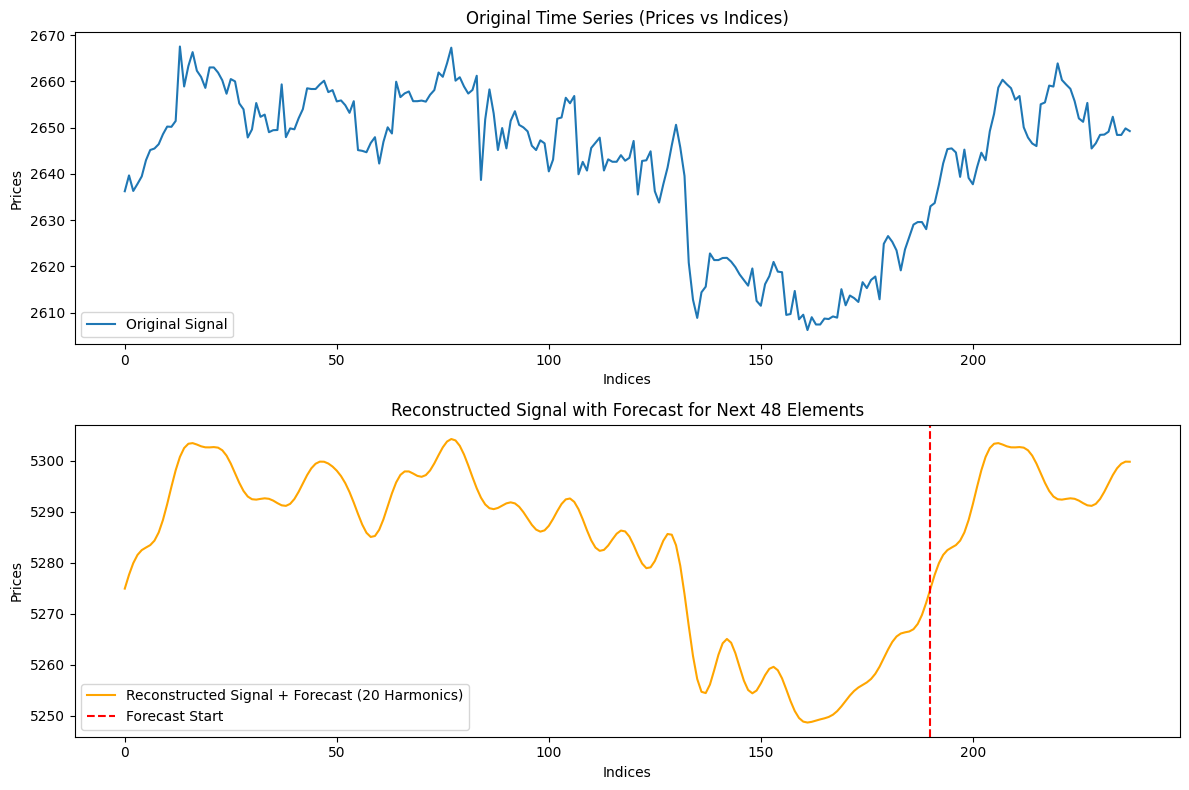

In [28]:
# Define how many elements to exclude (last 48)
exclude_elements = 48
prices_for_fft = prices[:-exclude_elements]  # Remove the last 48 elements for FFT

# Perform FFT on the data excluding the last 48 elements
fft_result = np.fft.fft(prices_for_fft)
fft_freq = np.fft.fftfreq(len(prices_for_fft))  # Compute frequency bins

# Filter out the positive frequencies
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain only the first few harmonics, e.g., the first 20 frequencies
num_harmonics = 20
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Create extended indices including future points
total_length = len(prices)
extended_indices = np.arange(total_length)

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(total_length)
for i in range(num_harmonics):
    amplitude = np.abs(amplitudes[i]) * 2 / len(prices_for_fft)
    phase = np.angle(amplitudes[i])
    frequency = frequencies[i]
    omega = 2 * np.pi * frequency
    reconstructed_signal += amplitude * np.cos(omega * extended_indices + phase)

# Plot original time series data and the forecast
plt.figure(figsize=(12, 8))

# Plot original signal
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(prices)), prices, label="Original Signal")
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot the reconstructed signal with forecast
plt.subplot(2, 1, 2)
plt.plot(extended_indices, reconstructed_signal, label=f"Reconstructed Signal + Forecast ({num_harmonics} Harmonics)", color='orange')
plt.axvline(x=len(prices) - exclude_elements, color='red', linestyle='--', label="Forecast Start")
plt.title(f"Reconstructed Signal with Forecast for Next {exclude_elements} Elements")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()
